In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 500

In [9]:
import os
DIVERSITY_UTILITY = 0.25
FRAC_ADMIT = 0.25

###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['key'] = df['R'].astype(str) + "_"  + df['T'].astype(str)

###
## Estimate E[Y(1)|T, A]
###

df_train = pd.read_csv('./df_train.csv')
df_stratum_utility = df_train[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_stratum_utility['utility_grad'] = (df_stratum_utility['Y']).round(2)
df_stratum_utility['stratum_utility'] = (df_stratum_utility['Y'] + DIVERSITY_UTILITY * df_stratum_utility['R']).round(2)
df_stratum_utility['key'] = df_stratum_utility['R'].astype(str) + "_" + df_stratum_utility['T'].astype(str)

df = df.merge(df_stratum_utility[['stratum_utility','utility_grad','key']], on='key')
df['ml_outcomes'] = df['stratum_utility']

In [10]:
TOTAL_ADMITS = int(len(df)*FRAC_ADMIT)


In [13]:
MAX_BLACK_ADMITS = TOTAL_ADMITS
MIN_GRADUATES = 75000
GRID_SIZE = 500


In [14]:
outcomes_grid = []
Xs = []
Ys = []

for N_black_admits in range(0,MAX_BLACK_ADMITS):
    
    if N_black_admits % GRID_SIZE != 0:
        continue
    
    black_admits = df[df['R']==1].sort_values(by='T',ascending=False).head(n=N_black_admits)
    white_admits = df[df['R']==0].sort_values(by='T',ascending=False).head(n=TOTAL_ADMITS-N_black_admits)
    
    Y = black_admits['Y'].sum() + white_admits['Y'].sum()
    
    Xs.append(N_black_admits)
    Ys.append(Y)
    print(N_black_admits,Y)
    
    for y_iter in np.arange(MIN_GRADUATES,Y,GRID_SIZE):
        outcomes_grid.append({'min_black_admits':N_black_admits-GRID_SIZE/2, 'max_black_admits':N_black_admits+GRID_SIZE/2, 'max_graduates':y_iter+GRID_SIZE, 'min_graduates':y_iter, 'policy_exists':'Unknown'})
        

0 180283
500 180479
1000 180650
1500 180801
2000 180948
2500 181082
3000 181223
3500 181345
4000 181472
4500 181592
5000 181693
5500 181773
6000 181884
6500 181981
7000 182083
7500 182154
8000 182232
8500 182323
9000 182360
9500 182426
10000 182512
10500 182598
11000 182663
11500 182741
12000 182811
12500 182877
13000 182955
13500 182978
14000 183016
14500 183048
15000 183120
15500 183169
16000 183215
16500 183266
17000 183314
17500 183369
18000 183398
18500 183470
19000 183523
19500 183611
20000 183630
20500 183659
21000 183682
21500 183702
22000 183744
22500 183762
23000 183791
23500 183806
24000 183807
24500 183844
25000 183843
25500 183841
26000 183858
26500 183869
27000 183875
27500 183886
28000 183874
28500 183851
29000 183861
29500 183854
30000 183835
30500 183820
31000 183818
31500 183798
32000 183803
32500 183824
33000 183813
33500 183822
34000 183831
34500 183796
35000 183795
35500 183769
36000 183730
36500 183709
37000 183673
37500 183650
38000 183646
38500 183650
39000 1836

In [15]:
df_pareto = pd.DataFrame({'# Black Admits':Xs, '# Graduates':Ys})

In [16]:
dff = df[['R','T','ml_outcomes','Y']].groupby(['R','T','Y']).count().reset_index()
dff.columns = ['R','T','Y','N']


In [17]:
from ortools.linear_solver import pywraplp
solver = pywraplp.Solver.CreateSolver('GLOP')


In [18]:
applicant_stratum = []
vars_cache = {}

# Objective: Maximize the expected utility of the admitted students
objective = solver.Objective()

# For each stratum
for ix, row in dff.iterrows():
    # probability of admission
    numvar = solver.NumVar(0.0, 1.0, str(ix))
    
    # store variable by index, and also by stratum R, T
    applicant_stratum.append(numvar)
    vars_cache[(row['R'],row['T'],row['Y'])] = numvar
    
    # Benefit of admitting people is simply the total number of people admitted
    objective.SetCoefficient(applicant_stratum[ix], float(row['N']))
objective.SetMaximization()


In [19]:
# Currently we have no constraints 
solver.NumConstraints()

# Constraint: At most K applicants
K = int(len(df)*FRAC_ADMIT)
print(K)
admit_quota = solver.Constraint(0, K)

# Total applicants cannot exceed K 
for ix, row in dff.iterrows():
    admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    
# Now we have one constraint
solver.NumConstraints()

249999


1

In [20]:
####
#### Add the CF equalized odds constraints
####


## Make sure that you have to add all people in Y stratum or none
## i.e. you can't add only people who pass boards and reject those who fail boards from same T, R stratum
didntexist, exists = 0, 0 

for ix, row in dff.iterrows():
    constrain_bp = solver.Constraint(0.0, 0.0)
    
    var1 = vars_cache[(row['R'],row['T'],row['Y'])]
    key2 = (row['R'],row['T'], 1-row['Y'])
    
    if key2 not in vars_cache:
        didntexist+=1
        continue
        
    var2 = vars_cache[key2]
    
    constrain_bp.SetCoefficient(var1, -1.0)
    constrain_bp.SetCoefficient(var2, 1.0)
    exists+=1

didntexist, exists

(48, 348)

In [21]:


majority_pass_boards = []
majority_fail_boards = []
minority_pass_boards = []
minority_fail_boards = []

for key in vars_cache:
    r, t, Y = key
    if Y == 1 and r==0:
        majority_pass_boards.append(key)
    elif Y == 0 and r==0:
        majority_fail_boards.append(key)
    elif Y == 1 and r==1:
        minority_pass_boards.append(key)
    elif Y == 0 and r==1:
        minority_fail_boards.append(key)

len(majority_pass_boards),len(majority_fail_boards),len(minority_pass_boards),len(minority_fail_boards)

NUM_TOTALS = {}
df_totals = dff[['N','R','Y']].groupby(['R','Y']).sum().reset_index()
for ix, row in df_totals.iterrows():
    NUM_TOTALS[(row['R'],row['Y'])] = row['N']
    
N_IN_STRATAS = {}
for ix, row in dff.iterrows():
    N_IN_STRATAS[(row['R'],row['T'],row['Y'])] = row['N']
    
# Now we have one constraint
solver.NumConstraints()

#Of those who pass the boards exams
#Frac majority admitted and frac minority admitted should be the same

constrain_pass_boards = solver.Constraint(0.0, 0.0)

for key in majority_pass_boards:
    r, t, Y = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y)]
    N_TOTAL = NUM_TOTALS[(r,Y)]
    
    constrain_pass_boards.SetCoefficient(vars_cache[key], float(N_IN_STRATUM) / float(N_TOTAL))

for key in minority_pass_boards:
    r, t, Y = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y)]
    N_TOTAL = NUM_TOTALS[(r,Y)]
    
    constrain_pass_boards.SetCoefficient(vars_cache[key], -1.0 * (float(N_IN_STRATUM) / float(N_TOTAL)))

#Of those who fail the boards exams
#Frac majority admitted and frac minority admitted should be the same

constrain_fail_boards = solver.Constraint(0.0, 0.0)

for key in majority_fail_boards:
    r, t, Y = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y)]
    N_TOTAL = NUM_TOTALS[(r,Y)]
    
    constrain_fail_boards.SetCoefficient(vars_cache[key], float(N_IN_STRATUM) / float(N_TOTAL))

for key in minority_fail_boards:
    r, t, Y = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y)]
    N_TOTAL = NUM_TOTALS[(r,Y)]
    
    constrain_fail_boards.SetCoefficient(vars_cache[key], -1.0 * (float(N_IN_STRATUM) / float(N_TOTAL)))


In [22]:
constrain_graduate = solver.Constraint(0, 0)

for ix, row in dff.iterrows():
    
    key = (row['R'],row['T'],row['Y'])
    n_graduate = row['Y'] * row['N']
    constrain_graduate.SetCoefficient(vars_cache[key], float(n_graduate))

constrain_black_admit = solver.Constraint(0, 0)

for ix, row in dff.iterrows():
    key = (row['R'],row['T'],row['Y'])
    n_black = row['R'] * row['N']
    constrain_black_admit.SetCoefficient(vars_cache[key], float(n_black))


In [25]:
len(outcomes_grid)

13531

In [23]:
count = 0 

print ('Total grid cells to check: {}'.format(len(outcomes_grid)))

for region in outcomes_grid:
    constrain_graduate.SetBounds(float(region['min_graduates']), float(region['max_graduates']))
    constrain_black_admit.SetBounds(float(region['min_black_admits']), float(region['max_black_admits']))
    status = solver.Solve()
    if status == 0:
        region['policy_exists'] = 1
        
        row = []
        admit = []

        for i in applicant_stratum:
            row.append(int(str(i)))
            admit.append(i.solution_value())
        #df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
        region['policy'] = (row,admit)    
    else:
        continue
        #print(status)
        
    count+=1
    
    if count % 100 ==0:
        print ('Total grid cells checked so far: {}/{}'.format(count,len(outcomes_grid)))




Total grid cells to check: 81924
Total grid cells checked so far: 100/81924
Total grid cells checked so far: 200/81924
Total grid cells checked so far: 300/81924
Total grid cells checked so far: 400/81924
Total grid cells checked so far: 500/81924
Total grid cells checked so far: 600/81924
Total grid cells checked so far: 700/81924
Total grid cells checked so far: 800/81924
Total grid cells checked so far: 900/81924
Total grid cells checked so far: 1000/81924
Total grid cells checked so far: 1100/81924
Total grid cells checked so far: 1200/81924
Total grid cells checked so far: 1300/81924
Total grid cells checked so far: 1400/81924
Total grid cells checked so far: 1500/81924
Total grid cells checked so far: 1600/81924
Total grid cells checked so far: 1700/81924
Total grid cells checked so far: 1800/81924
Total grid cells checked so far: 1900/81924
Total grid cells checked so far: 2000/81924
Total grid cells checked so far: 2100/81924
Total grid cells checked so far: 2200/81924
Total gr

In [24]:
outcomes_grid = pd.DataFrame(outcomes_grid)
outcomes_grid = outcomes_grid[outcomes_grid['policy_exists']==1]
outcomes_grid.to_csv('./outcomes_grid_cf_eo.csv')

In [26]:
outcomes_grid

,min_black_admits,max_black_admits,max_graduates,min_graduates,policy_exists,policy
11002,25250.0,25750.0,75500,75000,1,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
11003,25250.0,25750.0,76000,75500,1,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
11004,25250.0,25750.0,76500,76000,1,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
11220,25750.0,26250.0,75500,75000,1,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
11221,25750.0,26250.0,76000,75500,1,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
...,...,...,...,...,...,...
37647,87750.0,88250.0,76000,75500,1,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
37648,87750.0,88250.0,76500,76000,1,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
37649,87750.0,88250.0,77000,76500,1,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
37650,87750.0,88250.0,77500,77000,1,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."


In [26]:
import pickle
filehandler = open("Fruits.obj","wb")
pickle.dump(outcomes_grid,filehandler)
filehandler.close()


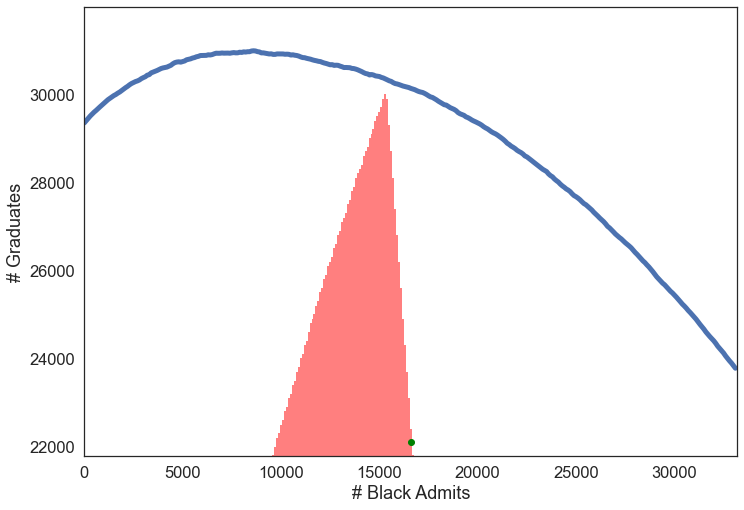

In [15]:
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="white", font_scale=1.5, )
ax = sns.lineplot(data=df_pareto, x='# Black Admits', y='# Graduates',linewidth=5)
errorboxes = []

for outcome_block in outcomes_grid:
    if outcome_block['policy_exists'] == 1:
        errorboxes.append(Rectangle((outcome_block['min_black_admits'] , outcome_block['min_graduates']),GRID_SIZE,GRID_SIZE))

pc = PatchCollection(errorboxes, facecolor='red', alpha=0.5,  edgecolor='none')
                       
ax.add_collection(pc)
plt.scatter(x=(df['R']*0.5).sum(),y=(df['Y']*0.5).sum(),color='green')   
plt.xlim([0, MAX_BLACK_ADMITS])
plt.ylim([df_pareto['# Graduates'].min()-2000, df_pareto['# Graduates'].max()+1000])
plt.show()


    


In [16]:
# Show utility maximizing policy 
acceptable_policies = [x for x in outcomes_grid if x['policy_exists']==1]
best_outcome = acceptable_policies[0]
for outcome in acceptable_policies:
    if outcome['max_graduates'] - 22000 < 100 and outcome['max_black_admits'] - 11000 < 100:
        best_outcome = outcome

In [17]:
constrain_graduate.SetBounds(float(21900), float(22000))
constrain_black_admit.SetBounds(float(10950.0), float(11050.0))
status = solver.Solve()
status

0

In [18]:
row = []
admit = []

for i in applicant_stratum:
    row.append(int(str(i)))
    admit.append(i.solution_value())


In [19]:
#row = best_outcome['policy'][0]
#admit = best_outcome['policy'][1]


df_decisions = pd.DataFrame({'row_id':row,'decision':admit})

dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='N',ascending=False)
viz = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='N',ascending=False)[['R','T','Y','decision']]



<AxesSubplot:xlabel='T', ylabel='decision'>

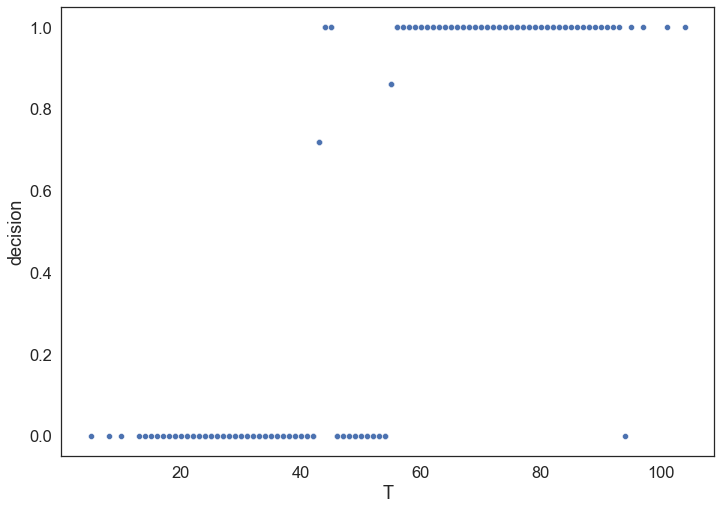

In [20]:
sns.scatterplot(data= viz[viz['R']==1], x='T',y='decision')

<AxesSubplot:xlabel='T', ylabel='decision'>

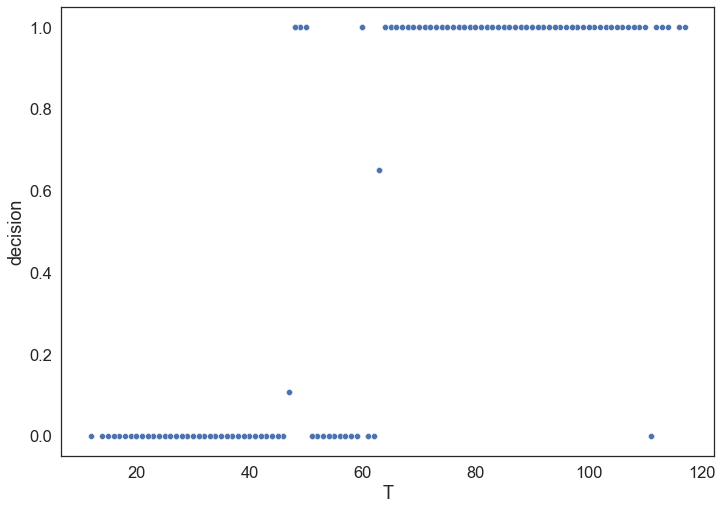

In [21]:
sns.scatterplot(data= viz[viz['R']==0], x='T',y='decision')

In [22]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)+'_'+df['Y'].astype(str)
viz['key'] = viz['R'].astype(str)+'_'+viz['T'].astype(str)+'_'+viz['Y'].astype(str)

admit_decisions = df.merge(viz[['key','decision']],how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT

NUM_MINORITY_POLICY = (admit_decisions['R'] * admit_decisions['decision']).sum()
SUM_BP_POLICY = ( admit_decisions['Y'] * admit_decisions['decision']).sum()

NUM_MINORITY_RANDOM = (admit_decisions['R'] * admit_decisions['decision_random']).sum()
SUM_BP_RAND_POLICY = ( admit_decisions['Y'] * admit_decisions['decision_random']).sum()

In [23]:
SUM_BP_POLICY, NUM_MINORITY_POLICY

(22000.0, 11050.0)

In [24]:
admit_decisions

,Unnamed: 0,R,E_noise,E_minority,E_majority,M_noise,M_minority,M_majority,T_noise,T_minority,T_majority,T_majority_star,T_minority_star,E,M,T,Y_unif,Y_reject_noise,Y,Y_raw,Y_reject,Y_reject_raw,key,stratum_utility,utility_grad,ml_outcomes,decision,decision_random
0,1,1,-0.938105,-0.938105,0.061895,0.215945,-1.722160,-0.722160,13.309506,54,61,57,57,-0.938105,-1.722160,54,0.028157,-0.149788,1,0.151593,1,0.097778,1_54_1,0.68,0.43,0.68,0.0,True
1,164,1,-1.017543,-1.017543,-0.017543,1.596718,-0.420824,0.579176,9.416984,54,62,58,57,-1.017543,-0.420824,54,0.405571,-0.867292,0,0.396320,0,0.284790,1_54_0,0.68,0.43,0.68,0.0,False
2,296,1,-1.342337,-1.342337,-0.342337,0.225058,-2.117280,-1.117280,15.124537,54,60,56,57,-1.342337,-2.117280,54,0.305624,-0.702129,0,0.107429,0,0.068035,1_54_0,0.68,0.43,0.68,0.0,True
3,387,1,0.896351,0.896351,1.896351,-0.346163,-0.449812,0.550188,2.296308,54,63,57,59,0.896351,-0.449812,54,0.116217,-0.452229,1,0.389405,1,0.278923,1_54_1,0.68,0.43,0.68,0.0,False
4,415,1,-0.064503,-0.064503,0.935497,0.545602,-0.518901,0.481099,6.499207,54,63,58,58,-0.064503,-0.518901,54,0.117010,-0.559411,1,0.373109,1,0.265242,1_54_1,0.68,0.43,0.68,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,91106,0,4.545513,4.545513,5.545513,0.603047,4.148560,5.148560,-7.272068,96,114,105,105,5.545513,5.148560,114,0.081535,-0.381280,1,0.994226,1,0.990515,0_114_1,0.98,0.98,0.98,1.0,True
99996,93421,1,3.547363,3.547363,4.547363,1.320808,3.868171,4.868171,10.821452,104,121,112,112,3.547363,3.868171,104,0.620890,-0.179486,1,0.979531,1,0.966695,1_104_1,1.25,1.00,1.25,1.0,True
99997,93449,0,3.327352,3.327352,4.327352,2.147981,4.475333,5.475333,0.182072,96,113,105,104,4.327352,5.475333,113,0.026484,-0.333233,1,0.995829,1,0.993141,0_113_1,0.99,0.99,0.99,1.0,False
99998,98989,0,2.589651,2.589651,3.589651,2.835858,4.425509,5.425509,7.820073,97,113,106,104,3.589651,5.425509,113,0.725754,-0.786882,1,0.995616,1,0.992793,0_113_1,0.99,0.99,0.99,1.0,False
